In [8]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

  
  



def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
     
    model = Sequential()
    model.add(Conv2D(64, (3, 3),
                      activation='elu',
                      padding='same',
                      input_shape=input_shape))
    
    model.add(Conv2D(64, (3, 3),
                      activation='elu',
                      padding='same',
                      input_shape=input_shape))
    
    model.add(Conv2D(64, (3, 3),
                      activation='elu',
                      padding='same',
                      input_shape=input_shape))
    
    model.add(Conv2D(64, (3, 3),
                      activation='elu',
                      padding='same',
                      input_shape=input_shape))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation ='elu'))
    

#     input = Input(shape=input_shape)
#     x = Flatten()(input)
#     x = Dense(128, activation='elu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='elu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='elu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='elu')(x)
    return model

  
  


  

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.astype('float32')
x_test = x_test.reshape(10000,28,28,1)
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 84s 778us/step - loss: 0.1868 - accuracy: 0.7762 - val_loss: 0.1185 - val_accuracy: 0.8549
Epoch 2/20
108400/108400 [==============================] - 84s 772us/step - loss: 0.1226 - accuracy: 0.8504 - val_loss: 0.1095 - val_accuracy: 0.8682
Epoch 3/20
108400/108400 [==============================] - 84s 773us/step - loss: 0.1151 - accuracy: 0.8639 - val_loss: 0.1058 - val_accuracy: 0.8770
Epoch 4/20
108400/108400 [==============================] - 84s 771us/step - loss: 0.1221 - accuracy: 0.8709 - val_loss: 0.0956 - val_accuracy: 0.8955
Epoch 5/20
108400/108400 [==============================] - 84s 772us/step - loss: 0.1078 - accuracy: 0.8782 - val_loss: 0.0989 - val_accuracy: 0.8910
Epoch 6/20
108400/108400 [==============================] - 84s 772us/step - loss: 0.1062 - accuracy: 0.8824 - val_loss: 0.0983 - val_accuracy: 0.8944
Epoch 7/20
108400/108400 [=================

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          6534080     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_2[1][0]               
          

In [26]:
# model.predict(y_test[:1])
y_test[:1]

array([7], dtype=uint8)

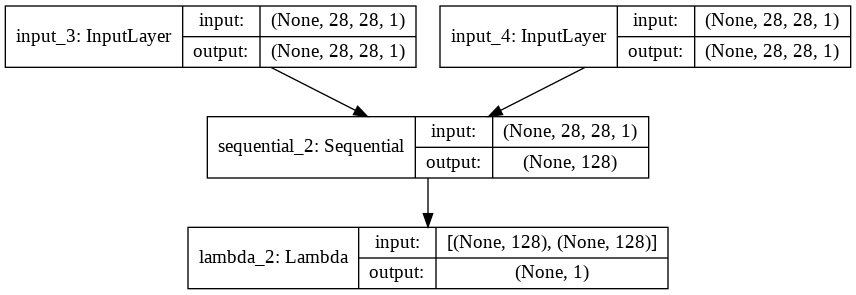

In [27]:

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')